In [71]:
import os
import glob
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sns.set(rc={'figure.figsize': (16, 10)})
sns.set(font_scale=1.1)

In [108]:
RESULT_DIRECTORY = 'suite'
RESULT_SUITES = (
    '5__10_5',
    '5__10_6b',
    '10__20_12',
    '15__30_20',
    '15__40_8',
    '20__40_8',
    # '20__40_15',
)

In [109]:
class Result:
    def __init__(self, type, max_partition_size, graph, nodes, threads, result, time):
        self.type = type
        self.max_partition_size = max_partition_size
        self.graph = graph
        self.nodes = nodes
        self.threads = threads
        self.result = result
        self.time = time

    def to_dict(self):
        return {
            'type': self.type,
            'max_partition_size': self.max_partition_size,
            'graph': self.graph,
            'nodes': self.nodes,
            'threads': self.threads,
            'result': self.result,
            'time': self.time
        }

    def __repr__(self):
        return f'Result(' \
               f'type={self.type},' \
               f'mps={self.max_partition_size},' \
               f'graph={self.graph},' \
               f'nodes={self.nodes},' \
               f'threads={self.threads},' \
               f'result={self.result},' \
               f'time={self.time}' \
               f')'


In [110]:
def load_mpi_results(suite):
    max_partition_size, graph = suite.split('__')
    max_partition_size = int(max_partition_size)

    results = []
    for nodes in os.listdir(f'./{RESULT_DIRECTORY}/{suite}/mpi'):
        for threads in os.listdir(f'./{RESULT_DIRECTORY}/{suite}/mpi/{nodes}'):
            filepath = glob.glob(f'./{RESULT_DIRECTORY}/{suite}/mpi/{nodes}/{threads}/*.o*')[0]

            result = -1
            time = -1

            with open(filepath) as file:
                for line in file.readlines():
                    rm = re.search(r'Global minimum is: (\d+)', line)
                    if rm:
                        result = int(rm.groups(0)[0])

                    tm = re.search(r'Time: (\d+)ms', line)
                    if tm:
                        time = int(tm.groups(0)[0])
            results.append(Result(
                'mpi',
                max_partition_size, graph,
                int(nodes), int(threads),
                result, time
            ))
    return np.array(results)

In [111]:
def load_data_results(suite):
    max_partition_size, graph = suite.split('__')
    max_partition_size = int(max_partition_size)

    results = []
    for threads in os.listdir(f'./{RESULT_DIRECTORY}/{suite}/data'):
        filepath = glob.glob(f'./{RESULT_DIRECTORY}/{suite}/data/{threads}/*.o*')[0]

        result = -1
        time = -1

        with open(filepath) as file:
            for line in file.readlines():
                rm = re.search(r'Global minimum is: (\d+)', line)
                if rm:
                    result = int(rm.groups(0)[0])

                tm = re.search(r'Time: (\d+)ms', line)
                if tm:
                    time = int(tm.groups(0)[0])
        results.append(Result(
            'data',
            max_partition_size, graph,
            1, int(threads),
            result, time
        ))
    return np.array(results)

In [112]:
def load_task_results(suite):
    max_partition_size, graph = suite.split('__')
    max_partition_size = int(max_partition_size)

    results = []
    for threads in os.listdir(f'./{RESULT_DIRECTORY}/{suite}/task'):
        filepath = glob.glob(f'./{RESULT_DIRECTORY}/{suite}/task/{threads}/*.o*')[0]

        result = -1
        time = -1

        with open(filepath) as file:
            for line in file.readlines():
                rm = re.search(r'Global minimum is: (\d+)', line)
                if rm:
                    result = int(rm.groups(0)[0])

                tm = re.search(r'Time: (\d+)ms', line)
                if tm:
                    time = int(tm.groups(0)[0])
        results.append(Result(
            'task',
            max_partition_size, graph,
            1, int(threads),
            result, time
        ))
    return np.array(results)

In [113]:
def load_sequential_results(suite):
    max_partition_size, graph = suite.split('__')
    max_partition_size = int(max_partition_size)

    filepath = glob.glob(f'./{RESULT_DIRECTORY}/{suite}/sequential/*.o*')[0]

    result = -1
    time = -1

    with open(filepath) as file:
        for line in file.readlines():
            rm = re.search(r'Global minimum is: (\d+)', line)
            if rm:
                result = int(rm.groups(0)[0])

            tm = re.search(r'Time: (\d+)ms', line)
            if tm:
                time = int(tm.groups(0)[0])
    return np.array([
        Result(
            'sequential',
            max_partition_size, graph,
            1, 1,
            result, time
        ),
        Result(
            'sequential',
            max_partition_size, graph,
            1, 20,
            result, time
        ),
    ])

In [114]:
def load_suite_result(suite):
    return np.concatenate((
        load_sequential_results(suite),
        load_task_results(suite),
        load_data_results(suite),
        load_mpi_results(suite)))

In [115]:
results = {}
for suite in RESULT_SUITES:
    results[suite] = load_suite_result(suite)

In [116]:
def plot_result(suite):
    max_partition_size, graph = suite.split('__')

    res_pd = pd.DataFrame.from_records([s.to_dict() for s in results[suite]])

    res_pd = res_pd.replace(-1, np.nan)
    res_pd['time_s'] = res_pd['time'].astype(float) / 1000

    ax = sns.lineplot(data=res_pd, x="threads", y="time_s", hue="type")
    ax.locator_params(integer=True)
    ax.set_xticks(res_pd['threads'].unique())
    ax.set(title=f'graf_{graph} a={max_partition_size}',
           xlabel='Number of threads',
           ylabel='Running time [s]')
    plt.show()

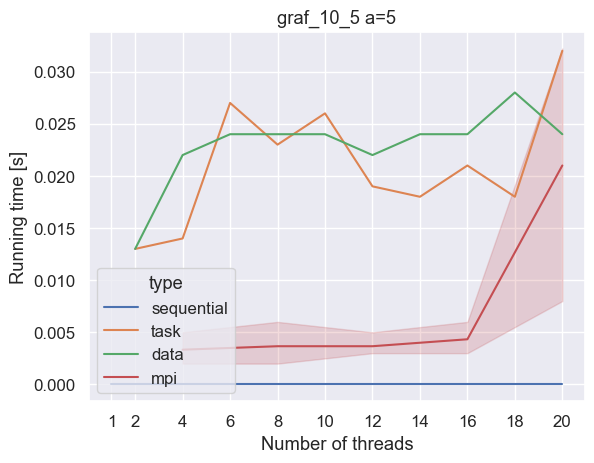

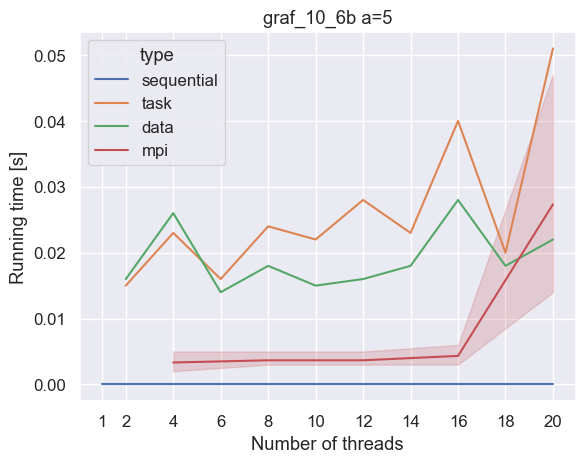

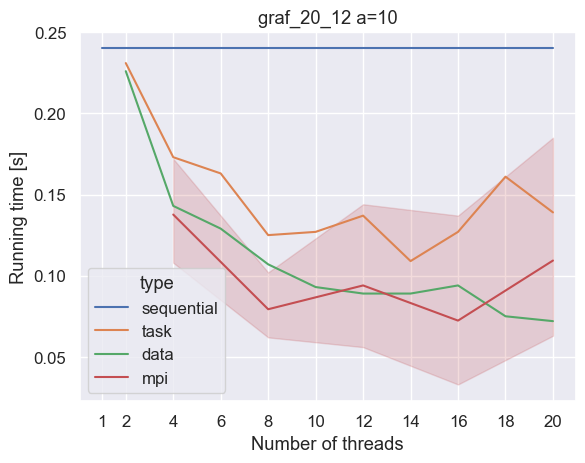

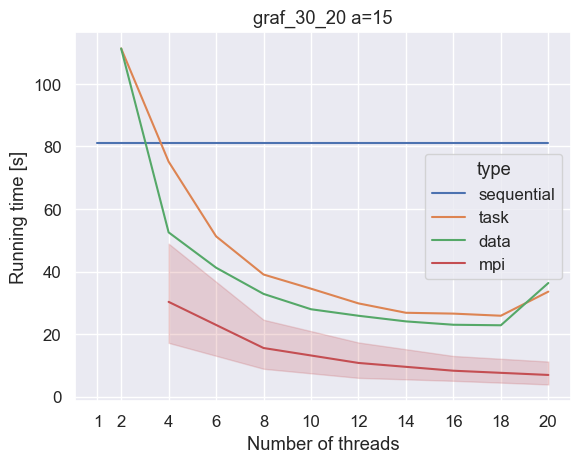

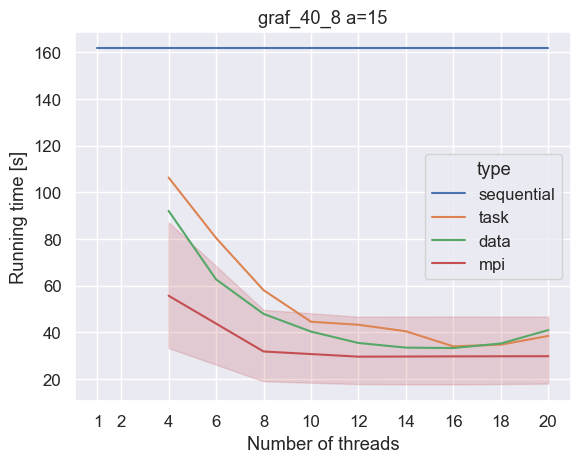

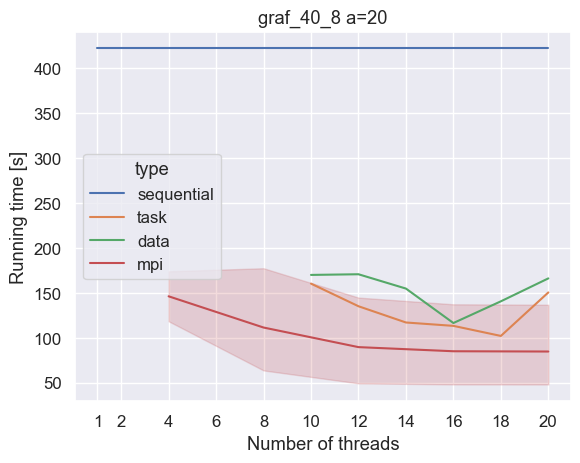

In [117]:
for suite in RESULT_SUITES:
    plot_result(suite)

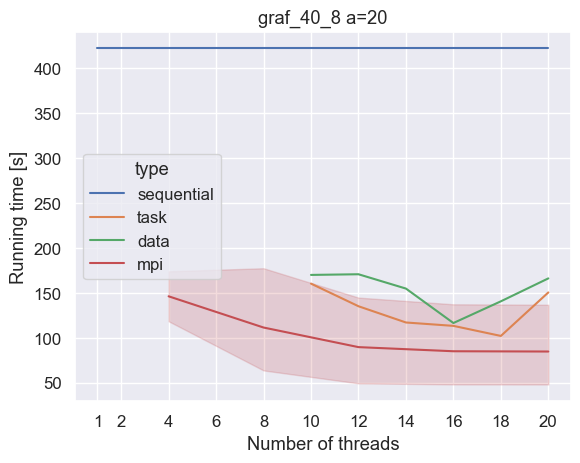

In [118]:
plot_result('20__40_8')